In [35]:
import data
import json

with open("reachable.json") as f:
    reachable_dict = {int(k): v for k, v in json.load(f).items()}

potential_facilities, location_directory, pid_assignment = data.get_data("charlottesville_city", 5, 6, 20)
print(len(potential_facilities), len(location_directory), sum(len(val) for val in pid_assignment.values()))

3142 13039 764


### Parallelized Algorithm for Cover

Todo:
* Check output with a smaller test data set
* Add some visualizations for clarity as to clients, facility location, etc.

#### Helper Functions

In [59]:
import geopy.distance

def calculate_dist(coord1, coord2):
    return geopy.distance.great_circle(coord1, coord2).km

In [60]:
import time

def cover_pid(fac_loc, loc_assignment, location_directory, radius, exclusion):
    cover_count = 0
    fac_coord = (location_directory[fac_loc]["latitude"], location_directory[fac_loc]["longitude"])
    
    for ind in range(len(loc_assignment)):
        loc = loc_assignment[ind]
        lid = loc[1]
        if lid not in exclusion:
            lid_coord = (location_directory[lid]["latitude"], location_directory[lid]["longitude"])
            if calculate_dist(fac_coord, lid_coord) <= radius:
                cover_count += 1

    return cover_count

In [61]:
def remove_pid_set(fac_loc, loc_assignment, location_directory, radius, exclusion):
    
    fac_coord = (location_directory[fac_loc]["latitude"], location_directory[fac_loc]["longitude"])
    
    removed = []
    
    for ind in range(len(loc_assignment)):
        loc = loc_assignment[ind]
        lid = loc[1]
        if lid not in exclusion:
            lid_coord = (location_directory[lid]["latitude"], location_directory[lid]["longitude"])
            if calculate_dist(fac_coord, lid_coord) <= radius:
                removed.append(lid)

    return removed

In [62]:
def fill_first(pf, reachable, loc_assignments, location_directory, radius, exclusion):
    if len(reachable)!=0:
        pf_count = cover_pid(pf, loc_assignments, location_directory, radius, exclusion)
    else:
        pf_count = 0
    
    return (pf, pf_count)

In [63]:
def fill_timestep(pf, reachable, loc_assignments, location_directory, radius, exclusion, dp, hr):
    
    if len(reachable) == 0:
        pf_count = 0
        pf_path = []
    else:
        largest_count, largest_path = max([(dp[reach][hr-1]["count"],
                                             dp[reach][hr-1]["path"]) for reach in reachable])
        
        pf_count = largest_count + cover_pid(pf, loc_assignments, location_directory, radius, exclusion)
        pf_path = largest_path + [pf]
    
    return (pf, pf_count, pf_path)

In [64]:
def calculate_reachable(potential_facilities, location_directory, m: float):
    
    potential_facilities_list = list(potential_facilities)
    reachable_dict = {}
    
    for p in range(len(potential_facilities_list)):
        # Can probably parallelize for speed
        for q in range(p, len(potential_facilities_list)):
            
            lid1, lid2 = potential_facilities_list[p], potential_facilities_list[q]
            
            coord1 = (location_directory[lid1]["latitude"], location_directions[lid1]["longitude"])
            coord2 = (location_directory[lid2]["latitude"], location_directions[lid2]["longitude"])
            dist = geopy.distance.great_circle(coord1, coord2).km
            
            if dist <= m:
                if lid1 not in reachable_dict.keys():
                    reachable_dict[lid1] = [lid2]
                else:
                    reachable_dict[lid1].append(lid2)
                
                if lid2 not in reachable_dict.keys():
                    reachable_dict[lid2] = [lid1]
                else:
                    reachable_dict[lid2].append(lid1)
    
    return reachable_dict

In [65]:
def remove_pid_set(fac_loc, loc_assignment, location_directory, radius, exclusion):
    
    fac_coord = (location_directory[fac_loc]["latitude"], location_directory[fac_loc]["longitude"])
    
    removed = []
    
    for ind in range(len(loc_assignment)):
        loc = loc_assignment[ind]
        lid = loc[1]
        if lid not in exclusion:
            lid_coord = (location_directory[lid]["latitude"], location_directory[lid]["longitude"])
            if calculate_dist(fac_coord, lid_coord) <= radius:
                removed.append(lid)

    return removed

In [66]:
import tqdm
from joblib import Parallel, delayed

def cover_fac_parallel(potential_facilities, location_directory, pid_assignment, reachable_dict):
    
    """
    TODO:
    implement binary search over radius
    """
    radius = 1.25
    
    dp = {}
    paths = []
    exclusion = {}
    START_OFFSET = 6

    for k in range(0, 5):
        
        for hr in tqdm.tqdm(range(6, 20)):
            
            loc_assignments = pid_assignment[hr]

            if hr == START_OFFSET:
                
                if hr not in exclusion.keys():
                    exclusion_set = set()
                else:
                    exclusion_set = exclusion[hr]
                
                results = Parallel(n_jobs=5)(delayed(fill_first)(pf, 
                        [r for r in reachable_dict[pf] if r in location_directory.keys()],
                        loc_assignments, location_directory, radius, exclusion_set)
                           for pf in potential_facilities)
                for pf, pf_count in results:
                    dp[pf]={hr:{
                        "count": pf_count,
                        "path": [pf]
                    }}
            else:
                
                if hr not in exclusion.keys():
                    exclusion_set = set()
                else:
                    exclusion_set = exclusion[hr]
                
                results = Parallel(n_jobs=5)(delayed(fill_timestep)(pf,
                            [r for r in reachable_dict[pf] if r in location_directory.keys()],
                                loc_assignments, location_directory, radius, exclusion_set, dp, hr)
                                             for pf in potential_facilities)
                for pf, pf_count, pf_path in results:
                    dp[pf][hr] = {
                        "count": pf_count,
                        "path": pf_path
                    }

        best_count, best_path = max([(dp[fac][hr]["count"],
                                      dp[fac][hr]["path"]) for fac in dp.keys()])
        paths.append(best_path)

        for h, fac in enumerate(best_path):
            loc_assignments = pid_assignment[h+START_OFFSET]
            
            removals = remove_pid_set(fac, loc_assignments, location_directory, radius, exclusion)
            
            if h+START_OFFSET not in exclusion.keys():
                exclusion[h+START_OFFSET] = set(removals)
            else:
                exclusion[h+START_OFFSET] = exclusion[h+START_OFFSET].union(set(removals))
        
        print("Exclusions: ", {k: len(val) for k, val in exclusion.items()})
        print(best_count, best_path)
    
    print(paths)
    return paths

In [67]:
potential_facilities, location_directory, pid_assignment = data.get_data("charlottesville_city", 5, 6, 20)

start = time.time()
cover_fac_parallel(potential_facilities, location_directory, pid_assignment, reachable_dict)
end = time.time()

print(end-start)

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [29:16<00:00, 125.44s/it]


Exclusions:  {6: 25, 7: 24, 8: 25, 9: 25, 10: 19, 11: 14, 12: 23, 13: 23, 14: 17, 15: 19, 16: 21, 17: 19, 18: 22, 19: 25}
305 [1414065, 2390164, 2390164, 2311433, 201428, 649144, 132716, 76435, 2100698, 2732510, 43022, 2021744, 2127148, 133613]


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [47:20<00:00, 202.86s/it]


Exclusions:  {6: 43, 7: 43, 8: 41, 9: 40, 10: 27, 11: 21, 12: 33, 13: 34, 14: 28, 15: 30, 16: 28, 17: 34, 18: 38, 19: 38}
181 [2179889, 438602, 623030, 134711, 2706020, 2468594, 2626710, 2653257, 2021713, 728600, 438498, 754973, 2285211, 1995343]


 93%|███████████████████████████████████████████████████████████████████████████▏     | 13/14 [32:26<03:36, 216.57s/it]C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [1:44:37<00:00, 448.40s/it]


Exclusions:  {6: 53, 7: 56, 8: 51, 9: 50, 10: 34, 11: 26, 12: 41, 13: 40, 14: 37, 15: 36, 16: 36, 17: 43, 18: 50, 19: 44}
119 [2705923, 2732488, 2653257, 2653281, 2626742, 42193, 2732575, 2732575, 2732535, 2285179, 254319, 438495, 2574269, 2732583]


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [14:49<00:00, 63.56s/it]


Exclusions:  {6: 60, 7: 61, 8: 55, 9: 57, 10: 38, 11: 30, 12: 44, 13: 45, 14: 45, 15: 40, 16: 40, 17: 50, 18: 57, 19: 50}
75 [2521316, 2653274, 2521252, 2574278, 2626710, 2705941, 2705922, 2732510, 2442482, 2416339, 1757309, 2732562, 2732509, 2626770]


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [14:30<00:00, 62.17s/it]

Exclusions:  {6: 66, 7: 65, 8: 58, 9: 60, 10: 40, 11: 33, 12: 46, 13: 49, 14: 48, 15: 43, 16: 42, 17: 52, 18: 59, 19: 55}
44 [2705977, 2390122, 2732535, 2653366, 2732488, 2653307, 2705941, 2732535, 1123469, 2732575, 2732535, 2705922, 2706030, 2705923]
[[1414065, 2390164, 2390164, 2311433, 201428, 649144, 132716, 76435, 2100698, 2732510, 43022, 2021744, 2127148, 133613], [2179889, 438602, 623030, 134711, 2706020, 2468594, 2626710, 2653257, 2021713, 728600, 438498, 754973, 2285211, 1995343], [2705923, 2732488, 2653257, 2653281, 2626742, 42193, 2732575, 2732575, 2732535, 2285179, 254319, 438495, 2574269, 2732583], [2521316, 2653274, 2521252, 2574278, 2626710, 2705941, 2705922, 2732510, 2442482, 2416339, 1757309, 2732562, 2732509, 2626770], [2705977, 2390122, 2732535, 2653366, 2732488, 2653307, 2705941, 2732535, 1123469, 2732575, 2732535, 2705922, 2706030, 2705923]]
12634.560851573944


##### Test Data Run

In [57]:
location_directory = {0: {"longitude": 0, "latitude": 0},
                      1: {"longitude": -1, "latitude": 0},
                      2: {"longitude": 0, "latitude": 1},
                      3: {"longitude": 1, "latitude": 1},
                      4: {"longitude": 0, "latitude": -0.5},
                      5: {"longitude": -1, "latitude": 1},
                      6: {"longitude": -5, "latitude": -5}}

potential_facilities = [0, 1, 5, 6]

pid_assignment = {6: [(0, 0), (1, 4)],
                  7:[(3, 5), (4, 1)],
                  8:[(5, 2), (7, 3)]}

new_reachable = {0:[1], 1: [0, 5], 5:[1], 6:[]}

start = time.time()
chosen_fac_paths = cover_fac_parallel(potential_facilities, location_directory, pid_assignment, new_reachable)
end = time.time()

print(end-start)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.41it/s]


Exclusions:  {6: 1, 7: 1, 8: 0}
2 [0, 1, 5]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.94it/s]


Exclusions:  {6: 1, 7: 2, 8: 0}
1 [1, 5, 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 106.35it/s]


Exclusions:  {6: 1, 7: 2, 8: 0}
1 [0, 1, 5]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 84.83it/s]


Exclusions:  {6: 1, 7: 2, 8: 0}
1 [0, 1, 5]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 98.93it/s]

Exclusions:  {6: 1, 7: 2, 8: 0}
1 [0, 1, 5]
[[0, 1, 5], [1, 5, 1], [0, 1, 5], [0, 1, 5], [0, 1, 5]]
0.15845608711242676


In [113]:
potential_facilities, location_directory, pid_assignment = data.get_data("charlottesville_city", 5, 6, 20)

potential_facilities_test = set(list(potential_facilities)[:10])
pid_assignment_test = {hr: [v for v in vals if v[1] in potential_facilities_test or v[1] not in potential_facilities]
                      for hr, vals in pid_assignment.items()}
reachable_test = {pf: [v for v in reachable_dict[pf] if v in potential_facilities_test] for pf in potential_facilities_test}

start = time.time()
test_fac_paths = cover_fac_parallel(potential_facilities_test, location_directory, pid_assignment_test, reachable_test)
end = time.time()

print(end-start)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Exclusions:  {6: 2013, 7: 1816, 8: 1598}
6737 [98326, 98326, 98326]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.41it/s]


Exclusions:  {6: 2013, 7: 1972, 8: 1742}
2800 [98326, 32797, 32797]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.99it/s]


Exclusions:  {6: 2013, 7: 1982, 8: 1751}
2474 [98326, 131099, 131099]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.06it/s]


Exclusions:  {6: 2013, 7: 1982, 8: 1751}
2454 [98326, 131099, 131099]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]

Exclusions:  {6: 2013, 7: 1982, 8: 1751}
2454 [98326, 131099, 131099]
[[98326, 98326, 98326], [98326, 32797, 32797], [98326, 131099, 131099], [98326, 131099, 131099], [98326, 131099, 131099]]
3.3308966159820557


2739 2739
2553 2553
2184 2184


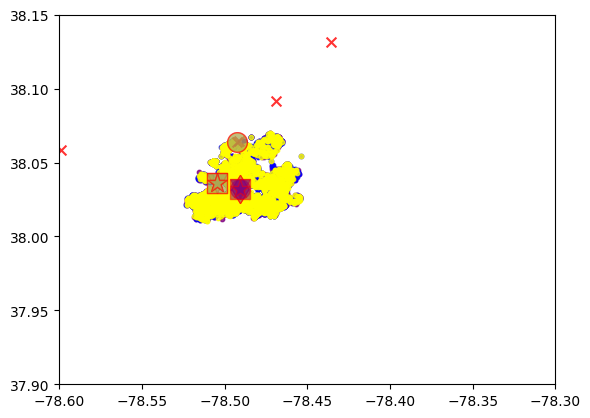

In [117]:
from matplotlib import pyplot as plt

color_array = [ "purple", "blue", "yellow", "green"]

hr_count = 0
for hr, vals in pid_assignment_test.items():
    if hr < 9:
        client_lats = []
        client_longs = []

        for v in vals:
            client_longs.append(location_directory[v[1]]["longitude"])
            client_lats.append(location_directory[v[1]]["latitude"])

        print(len(client_lats), len(client_longs))
        plt.scatter(client_longs, client_lats, color=color_array[hr_count], s = 10, alpha=0.8)
        
        hr_count+=1


potential_facility_locs_lat = [location_directory[pf]["latitude"] for pf in potential_facilities_test]
potential_facility_locs_long = [location_directory[pf]["longitude"] for pf in potential_facilities_test]
plt.scatter(potential_facility_locs_long, potential_facility_locs_lat, color='red', s = 50, marker='x', alpha=0.8)


shape_array = ['d', 'o', 'v', 's', '*']
for k_count in range(0, 5):
    
    for i, p in enumerate(test_fac_paths[k_count]):
        facs_lats = []
        facs_longs = []
        facs_longs.append(location_directory[p]["longitude"])
        facs_lats.append(location_directory[p]["latitude"])
        plt.scatter(facs_longs, facs_lats, color=color_array[i], alpha = 0.5, s = 200, edgecolors = 'red', marker=shape_array[k_count])

plt.xlim((-78.6, -78.3))
plt.ylim((37.9, 38.15))
plt.show()

### Cover Fac Parallel Binary Search

In [5]:
import time

def cover_pid_2(fac_loc, loc_assignment, location_directory, radius):
    
    cover_count = 0
    fac_coord = (location_directory[fac_loc]["latitude"], location_directory[fac_loc]["longitude"])
    
    coverage = set()
    
    for ind in range(len(loc_assignment)):
        loc = loc_assignment[ind]
        lid = loc[1]
        
        lid_coord = (location_directory[lid]["latitude"], location_directory[lid]["longitude"])
        if calculate_dist(fac_coord, lid_coord) <= radius:
            cover_count += 1
            coverage.add(loc[0])

    return cover_count, coverage

In [ ]:
def initialize_timestep_2(pf, reachable, loc_assignments, location_directory, radius):
    
    if len(reachable) == 0:
        pf_count = 0
        coverage = set()
    else:
        pf_count, coverage = cover_pid_2(pf, loc_assignments, location_directory, radius)
    
    return (pf, pf_count, coverage)


In [7]:
def fill_timestep_2(pf, reachable, loc_assignments, dp):
    
    if len(reachable) == 0:
        max_count = 0
        max_path = set()
    else:
        max_count, max_path = max((dp[adj]["count"], dp[adj]["path"]) for adj in reachable)
    
    return (pf, max_count, max_path)

In [24]:
from joblib import Parallel, delayed


def reachable(potential_facilities, location_directory, lid_1, m):
    reachable = []
    
    for lid_2 in potential_facilities:
        
        coord_1 = (location_directory[lid_1]["latitude"], location_directory[lid_1]["longitude"])
        coord_2 = (location_directory[lid_2]["latitude"], location_directory[lid_2]["longitude"])

        dist = calculate_dist(coord_1, coord_2)
        if dist<=m:
            reachable.append(lid_2)
    
    return (lid_1, reachable)

def calculate_reachable(potential_facilities, location_directory, m):
    
    
    results = Parallel(n_jobs=5)(delayed(reachable)
                            (potential_facilities, location_directory, pf, m)
                                 for pf in potential_facilities)
    
    reachable_dict = {pf: reachable for pf,reachable in results}
    return reachable_dict
        

In [25]:
start = time.time()
reachable_dict = calculate_reachable(potential_facilities, location_directory, 8)
end = time.time()
print(end-start)

51.53704071044922


In [26]:
print(reachable_dict[450])

[122888, 98326, 131099, 32795, 32797, 73757, 73758, 8233, 98345, 49206, 16444, 16445, 16446, 16447, 90175, 16449, 16450, 106563, 106561, 2547776, 131152, 98387, 2547797, 122966, 106585, 73817, 89, 2547806, 106591, 65632, 2547810, 98405, 2547820, 2547825, 106610, 57459, 57460, 73846, 57468, 2547839, 106624, 57473, 2547840, 123007, 32906, 1704078, 2547855, 41105, 2547857, 131227, 123038, 57502, 2547876, 57511, 2547879, 2547882, 1704107, 2547884, 2547887, 131250, 131252, 1704117, 32950, 2547895, 32952, 1704120, 1704122, 98496, 2547907, 131268, 2547908, 1704131, 65735, 49351, 123080, 123082, 2547912, 1704135, 41157, 1704143, 16592, 16591, 8402, 1704146, 1704155, 8417, 8418, 8419, 106724, 32997, 1704166, 123111, 232, 233, 234, 32999, 1704165, 1704174, 33011, 33012, 1466611, 131320, 98553, 1704187, 82174, 131326, 57598, 24837, 1466629, 123144, 1704201, 98570, 33037, 8468, 74009, 90396, 1466657, 131365, 114981, 1466661, 98600, 106792, 1466665, 1466662, 1466664, 1466668, 106800, 90419, 82229, 

In [19]:
with open("reachable.json") as f:
    reachable_dict_2 = {int(k): v for k, v in json.load(f).items()}

In [29]:
print(set(reachable_dict[450]).difference(reachable_dict_2[450]))

{43278, 43281, 69677, 96058, 69696, 69699, 69703, 96085, 122471, 69759, 69765, 122502, 69769, 96138, 122514, 17046, 96151, 69784, 122519, 96166, 96167, 17065, 43177, 96174, 17071, 69807, 122552, 122554, 43209, 17102, 17106, 17109, 122585, 43227, 43255}


35


In [8]:
import tqdm
from joblib import Parallel, delayed

def cover_fac_parallel_r_2(potential_facilities, location_directory, pid_assignment, reachable_dict, k_facs, radius):
    
    paths = []
    total_coverage = 0
    
    START_OFFSET = min(pid_assignment.keys())
    END_TIME = max(pid_assignment.keys())
    
    dp = {START_OFFSET-1: {pf: {"count": 0, "path": []} for pf in potential_facilities}}
    fac_client = {}

    for k in tqdm.tqdm(range(0, k_facs)):
        
        for hr in range(START_OFFSET, END_TIME+1):
            
            dp[hr] = {}
            loc_assignments = pid_assignment[hr]
            
            if k==0:
                results = Parallel(n_jobs=5)(delayed(initialize_timestep_2)
                                            (pf, [r for r in reachable_dict[pf] if r in location_directory.keys()],
                                             loc_assignments, location_directory, radius)
                                                 for pf in potential_facilities)
                fac_client[hr] = {fac: {"count": count, "coverage": coverage} for fac, count, coverage in results}

            chosen_max = Parallel(n_jobs=5)(delayed(fill_timestep_2)(pf, [r for r in reachable_dict[pf] if r in location_directory.keys()], loc_assignments, dp[hr-1])
                                            for pf in potential_facilities)
            
            for pf, max_count, max_path in chosen_max:
                dp[hr][pf] = {"count":max_count + fac_client[hr][pf]["count"],
                                 "path": max_path + [pf]}

        best_count, best_path = max([(dp[hr][fac]["count"],
                                      dp[hr][fac]["path"]) for fac in potential_facilities])
        paths.append(best_path)

        for i, fac in enumerate(best_path):
            
            h = i + START_OFFSET
            
            covered_clients = fac_client[h][fac]["coverage"]
            #print(fac, len(covered_clients))
            
            for pf in potential_facilities:
                fac_client[h][pf]["coverage"] = fac_client[h][pf]["coverage"].difference(covered_clients)
                fac_client[h][pf]["count"] = len(fac_client[h][pf]["coverage"])
            
            fac_client[h][fac]["coverage"] = set()
            fac_client[h][fac]["count"] = 0
        
        print(best_count, best_path)
        
        total_coverage += best_count
    
    return total_coverage, paths

In [9]:
#import tqdm
import tqdm

def cover_fac_binary_2(potential_facilities, location_directory, pid_assignment, m, k_facs):
    
    """
    TODO: configure m
    """
    
    l = 0
    r = 3
    
    epsilon = 1e-3
    alpha = 1
    
    radius_paths = []
    opt_radius = r
    total_clients = sum(len(val) for val in pid_assignment.values())
    print(total_clients)
    
    while r-l > 1e-3:
        
        mid = (l+r)/2
        
        client_coverage, paths = cover_fac_parallel_r_2(potential_facilities, location_directory,
                                                        pid_assignment, reachable_dict, k_facs, mid)
        print(mid, client_coverage)
        
        if client_coverage < total_clients:
            l = mid
        else:
            radius_paths = paths
            opt_radius = mid
            r = mid
    
    return opt_radius, radius_paths

In [10]:
opt_radius, paths = cover_fac_binary_2(potential_facilities, location_directory, pid_assignment, -1, 5)
print(paths)

764


 20%|████████████████▊                                                                   | 1/5 [01:30<06:00, 90.22s/it]

374 [1546037, 134126, 2653281, 2337742, 95603, 2547806, 2600237, 16447, 2416397, 1123501, 2311433, 1360912, 1123501, 70270]


 40%|█████████████████████████████████▌                                                  | 2/5 [02:18<03:15, 65.27s/it]

178 [2390153, 1942543, 2074415, 2285120, 2732509, 2706039, 2442376, 438498, 77880, 2679587, 1281926, 2732501, 2732562, 2626770]


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:07<01:56, 58.14s/it]

110 [2285120, 2653250, 2705922, 2626770, 2732535, 2732509, 2706020, 1968994, 2705941, 2653250, 2732509, 2732535, 2705977, 2732488]


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:53<00:53, 53.23s/it]

66 [2285179, 2653274, 2732583, 2732575, 2679587, 2416339, 2732509, 2494967, 132654, 2732510, 2706039, 2732562, 965375, 2706020]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:37<00:00, 55.53s/it]


26 [2442376, 2653338, 2705977, 2285179, 2653248, 2732562, 2416402, 2653311, 2705918, 2732535, 2574269, 2732488, 2732583, 2600299]
1.5 754


 20%|████████████████▌                                                                  | 1/5 [01:46<07:05, 106.31s/it]

587 [2047809, 2258515, 2337775, 2521228, 2547806, 2547806, 51152, 2337775, 2363976, 1677973, 1387381, 2127148, 2653323, 42168]


 40%|█████████████████████████████████▌                                                  | 2/5 [02:43<03:51, 77.24s/it]

108 [1097348, 2285126, 2574269, 2468664, 2653250, 2547839, 2706026, 2732535, 2679509, 438538, 2653250, 42301, 2258515, 2574234]


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:31<02:08, 64.25s/it]

56 [2732575, 2574269, 2732510, 2732583, 2732510, 2468594, 2547797, 2732583, 2732562, 2732535, 2732562, 2732510, 64116, 2285179]


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:27<01:00, 60.73s/it]

12 [2732510, 2732583, 2732583, 2732528, 2732583, 2732583, 2732510, 2732583, 2732510, 2732583, 2732510, 2732583, 2732583, 2732583]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:21<00:00, 64.20s/it]


1 [2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732583, 2732510, 2732583]
2.25 764


 20%|████████████████▌                                                                  | 1/5 [01:40<06:42, 100.61s/it]

494 [128561, 2390169, 2127148, 1387381, 1308444, 135070, 1863118, 1968881, 2258512, 2416397, 2547806, 98326, 2311433, 35942]


 40%|█████████████████████████████████▌                                                  | 2/5 [02:28<03:28, 69.50s/it]

143 [2732501, 2732562, 2653291, 1202579, 2732510, 2521261, 2468583, 2732575, 702063, 2679509, 115840, 2179855, 2285179, 2732575]


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:18<02:01, 60.51s/it]

78 [2574269, 2732510, 2732535, 2732562, 2732535, 2732583, 2732575, 2179855, 2547912, 2732510, 2706020, 2732501, 2732575, 2732510]


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:19<02:13, 66.59s/it]
exception calling callback for <Future at 0x2a337942800 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib

KeyboardInterrupt: 

exception calling callback for <Future at 0x2a337ff2bc0 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\al146\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\al146\App

In [109]:
!python -m pip install folium

     ---------------------------------------- 95.0/95.0 kB 5.3 MB/s eta 0:00:00


In [10]:
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster

lat_sum = 0
long_sum = 0
count = 0
for hr, vals in pid_assignment.items():
    for pid, lid in vals:
        lat_sum += location_directory[lid]["latitude"]
        long_sum += location_directory[lid]["longitude"]
        count+=1

MEDIAN_LAT = lat_sum/count
MEDIAN_LONG = long_sum/count

In [11]:
geo_map = folium.Map(location=[MEDIAN_LAT, MEDIAN_LONG], zoom_start=5)
m_cluster = MarkerCluster().add_to(geo_map)

for hr, vals in pid_assignment.items():
    for pid, lid in vals:

        lat = location_directory[lid]["latitude"]
        long = location_directory[lid]["longitude"]

        folium.Marker((lat, long),
          popup=f"<div><b>Pid</b>:{pid} ({lat:.5f}, {long:.5f}) <b>Lid</b>: {lid} <b>Hour</b>: {hr} <br/></div>",
          tooltip=pid,
          icon=folium.Icon(color='black',icon_color='#FFFF00')).add_to(m_cluster)

In [12]:
geo_map

In [32]:
import tqdm
from joblib import Parallel, delayed

def cover_fac_parallel_r(potential_facilities, location_directory, pid_assignment, reachable_dict, k_facs, radius):
    
    """
    TODO:
    store coverage from first set of timesteps traversal
    """
    
    dp = {}
    fac_client = {}
    paths = []
    exclusion = {}
    total_coverage = 0
    
    START_OFFSET = sorted(list(pid_assignment.keys()))[0]

    for k in range(0, k_facs):
        
        for hr in tqdm.tqdm(range(6, 8)):
            
            loc_assignments = pid_assignment[hr]

            if hr == START_OFFSET:
                
                if hr not in exclusion.keys():
                    exclusion_set = set()
                else:
                    exclusion_set = exclusion[hr]

                results = Parallel(n_jobs=5)(delayed(fill_first)(pf, reachable_dict[pf], loc_assignments, location_directory, radius, exclusion_set)
                       for pf in potential_facilities)

                for pf, pf_count in results:
                    dp[pf]={hr:{
                        "count": pf_count,
                        "path": [pf]
                    }}
            else:
                
                if hr not in exclusion.keys():
                    exclusion_set = set()
                else:
                    exclusion_set = exclusion[hr]

                results = Parallel(n_jobs=5)(delayed(fill_timestep)(pf, reachable_dict[pf], loc_assignments, location_directory, radius, exclusion_set, dp, hr)
                                         for pf in potential_facilities)
                
                for pf, pf_count, pf_path in results:
                    dp[pf][hr] = {
                        "count": pf_count,
                        "path": pf_path
                    }

        best_count, best_path = max([(dp[fac][hr]["count"],
                                      dp[fac][hr]["path"]) for fac in dp.keys()])
        paths.append(best_path)

        for h, fac in enumerate(best_path):
            loc_assignments = pid_assignment[h+START_OFFSET]
            
            removals = remove_pid_set(fac, loc_assignments, location_directory, radius, exclusion)
            
            if h+START_OFFSET not in exclusion.keys():
                exclusion[h+START_OFFSET] = set(removals)
            else:
                exclusion[h+START_OFFSET] = exclusion[h+START_OFFSET].union(set(removals))
        
        print("Exclusions: ", {k: len(val) for k, val in exclusion.items()})
        
        print(best_count, best_path)
        
        total_coverage += best_count
    
    return total_coverage, paths

In [35]:
#import tqdm
import tqdm

def cover_fac_binary(potential_facilities, location_directory, pid_assignment, m, k_facs):
    
    """
    TODO: configure m
    """
    
    l = 0.1
    r = 4
    
    epsilon = 1e-3
    alpha = 1
    
    radius_paths = []
    opt_radius = r
    total_clients = sum(len(val) for val in pid_assignment.values())
    print(total_clients)
    
    while r-l > 1e-3:
        
        mid = (l+r)/2
        
        client_coverage, paths = cover_fac_parallel_r(potential_facilities, location_directory, pid_assignment, reachable_dict, k_facs, mid)
        print(mid, client_coverage)
        
        if client_coverage < total_clients:
            l = mid
        else:
            radius_paths = paths
            opt_radius = mid
            r = mid
    
    return radius_paths

In [36]:
paths = cover_fac_binary(potential_facilities, location_directory, pid_assignment, -1, 2)
print(paths)

474


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:31<00:00, 70.35s/it]


Exclusions:  {6: 31, 7: 37, 8: 21}
89 [1387381, 132762, 2521228]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:21<00:00, 47.19s/it]


Exclusions:  {6: 37, 7: 49, 8: 26}
23 [2285181, 36528, 2653358]
2.05 112


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:28<00:00, 69.43s/it]


Exclusions:  {6: 38, 7: 52, 8: 28}
118 [2547810, 2626728, 2521304]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [16:06<00:00, 322.19s/it]


Exclusions:  {6: 39, 7: 54, 8: 30}
5 [2732535, 2732528, 99488]
3.025 123


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:44<00:00, 54.70s/it]


Exclusions:  {6: 40, 7: 54, 8: 29}
123 [1809934, 2626728, 2653323]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.89s/it]


Exclusions:  {6: 40, 7: 54, 8: 31}
2 [2732583, 2547776, 135758]
3.5125 125


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:55<00:00, 38.49s/it]


Exclusions:  {6: 40, 7: 54, 8: 29}
123 [2732488, 2732488, 2679587]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:46<00:00, 55.62s/it]


Exclusions:  {6: 40, 7: 54, 8: 31}
2 [2732583, 2732535, 116604]
3.75625 125


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:11<00:00, 43.98s/it]


Exclusions:  {6: 40, 7: 54, 8: 29}
123 [2732488, 2732488, 2732488]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:57<00:00, 59.25s/it]


Exclusions:  {6: 40, 7: 54, 8: 31}
2 [2732583, 2732535, 116604]
3.878125 125


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:09<00:00, 103.17s/it]


Exclusions:  {6: 40, 7: 54, 8: 29}
123 [2732488, 2732488, 2732488]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:46<00:00, 55.49s/it]


Exclusions:  {6: 40, 7: 54, 8: 31}
2 [2732583, 2732535, 116604]
3.9390625 125


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:52<00:00, 57.50s/it]


Exclusions:  {6: 40, 7: 54, 8: 29}
123 [2732488, 2732488, 2732488]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:00<00:00, 60.32s/it]


Exclusions:  {6: 40, 7: 54, 8: 31}
2 [2732583, 2732535, 116604]
3.96953125 125


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:46<00:00, 55.53s/it]


Exclusions:  {6: 40, 7: 54, 8: 29}
123 [2732488, 2732488, 2732488]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:44<00:00, 54.94s/it]


Exclusions:  {6: 40, 7: 54, 8: 31}
2 [2732583, 2732535, 116604]
3.984765625 125


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:48, 48.26s/it]


KeyboardInterrupt: 

In [7]:
import data
import json

with open("reachable.json") as f:
    reachable_dict = {int(k): v for k, v in json.load(f).items()}

potential_facilities, location_directory, pid_assignment = data.get_data("charlottesville_city", 5, 6, 20)

### Cover Fac w/o Parallel

In [ ]:
#import tqdm
import tqdm

def cover_fac(potential_facilities, location_directory, pid_assignment):
    
    radius = 5
    
    dp = {}
    paths = []
    exclusion = set()
    
    START_OFFSET = 6
    
    #for ind, hr in enumerate(sorted(pid_assignment.keys())):
    #for hr in tqdm.tqdm(range(6, 20)):
    
    for k in range(0, 2):
        
        for hr in tqdm.tqdm(range(6, 9)):
            
            loc_assignments = pid_assignment[hr]
            print(len(loc_assignments))

            if hr == START_OFFSET:
                reachable_count = 0
                for pf in tqdm.tqdm(potential_facilities):
                    if len(reachable_dict[pf])!=0:
                        reachable_count+=1
                        pf_count = cover_pid(pf, loc_assignments, location_directory, radius, exclusion)
                    else:
                        pf_count = 0

                    dp[pf] = {hr: 
                              {"count":pf_count,
                               "path":[pf]}
                             }
                #print(reachable_count)
            else:
                
                for pf in tqdm.tqdm(potential_facilities):
                    
                    reachable = reachable_dict[pf]
                    
                    if len(reachable) == 0:
                        dp[pf][hr]["count"] = 0
                    else:
                        """
                        Maybe have the distance of clients and potential facilit locations pre-calculated in sorted order?
                        Maybe add a shortcut to max and avoid calculating the coverage of those with significnatly low memoized values?
                        Maybe alter cover_pid to recognize when something has already been computed before (i.e. pf-pf pairs)?
                        Parallelize this for loop?
                        """

                        largest_count, largest_path = max([(dp[reach][hr-1]["count"],
                                                             dp[reach][hr-1]["path"]) for reach in reachable])
                        dp[pf][hr] = {
                            "count": largest_count + cover_pid(pf, loc_assignments, location_directory, radius, exclusion),
                            "path": largest_path + [pf]
                        }

        best_count, best_path = max([(dp[fac][hr]["count"],
                                      dp[fac][hr]["path"]) for fac in dp.keys()])
        paths.append(best_path)
        
        removals = []
        for h, fac in enumerate(best_path):
            loc_assignments = pid_assignment[h+START_OFFSET]
            removals += remove_pid_set(fac, loc_assignments, location_directory, radius, exclusion)
        
        exclusion = exclusion.union(set(removals))
        print(best_count, best_path)
    
    print(paths)

In [44]:
start = time.time()
paths = cover_fac(potential_facilities, location_directory, pid_assignment)
end = time.time()

print(end-start)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

3047



  3%|██▍                                                                            | 307/9728 [00:18<07:07, 22.06it/s]


  7%|█████▌                                                                         | 687/9728 [00:37<07:09, 21.06it/s]


 11%|████████▌                                                                     | 1075/9728 [00:55<06:15, 23.07it/s]


 15%|███████████▊                                                                  | 1467/9728 [01:13<08:37, 15.97it/s]


 19%|██████████████▉                                                               | 1862/9728 [01:31<06:07, 21.38it/s]


 23%|██████████████████                                                            | 2254/9728 [01:50<05:49, 21.37it/s]


 27%|█████████████████████▏                                                        | 2644/9728 [02:08<05:15, 22.46it/s]


 31%|████████████████████████▍                                                     | 3040/9728 [02:26<04:47, 23.28it/s]


 35%|███████████████████████████▌                                                  | 3442/9728 [02:45<05:16, 19.86it/s]


 39%|██████████████████████████████▌                                               | 3813/9728 [03:03<04:26, 22.20it/s]


 43%|█████████████████████████████████▋                                            | 4194/9728 [03:21<03:59, 23.15it/s]


 47%|████████████████████████████████████▊                                         | 4590/9728 [03:39<04:24, 19.43it/s]


 50%|███████████████████████████████████████▎                                      | 4902/9728 [03:58<06:09, 13.08it/s]


 54%|█████████████████████████████████████████▉                                    | 5236/9728 [04:17<03:29, 21.48it/s]


 58%|████████████████████████████████████████████▉                                 | 5598/9728 [04:36<03:02, 22.63it/s]


 61%|███████████████████████████████████████████████▏                              | 5892/9728 [28:54<04:01, 15.88it/s]


 64%|█████████████████████████████████████████████████▉                            | 6229/9728 [29:12<02:56, 19.85it/s]


 68%|████████████████████████████████████████████████████▉                         | 6606/9728 [29:31<02:04, 25.13it/s]


 72%|███████████████████████████████████████████████████████▉                      | 6982/9728 [29:49<01:53, 24.12it/s]


 76%|███████████████████████████████████████████████████████████                   | 7368/9728 [30:08<01:53, 20.82it/s]


 80%|██████████████████████████████████████████████████████████████▎               | 7764/9728 [30:26<01:30, 21.67it/s]


 84%|█████████████████████████████████████████████████████████████████▍            | 8162/9728 [30:44<01:08, 23.00it/s]


 88%|████████████████████████████████████████████████████████████████████▌         | 8549/9728 [31:02<00:55, 21.13it/s]


 92%|███████████████████████████████████████████████████████████████████████▋      | 8934/9728 [31:21<00:38, 20.84it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 9334/9728 [31:39<00:18, 21.08it/s]


 50%|█████████████████████████████████████████                                         | 1/2 [31:57<31:57, 1917.48s/it]

2941



  4%|███                                                                            | 372/9728 [00:23<07:23, 21.12it/s]


  8%|██████▏                                                                        | 762/9728 [00:41<06:37, 22.53it/s]


 12%|████████▉                                                                     | 1119/9728 [01:00<09:48, 14.64it/s]


 15%|████████████                                                                  | 1505/9728 [01:18<06:29, 21.14it/s]


 18%|██████████████                                                              | 1799/9728 [55:33<3:41:11,  1.67s/it]


 22%|█████████████████▎                                                            | 2156/9728 [56:09<08:37, 14.63it/s]


 26%|████████████████████▍                                                         | 2545/9728 [56:26<04:38, 25.83it/s]


 30%|███████████████████████▏                                                      | 2897/9728 [56:44<06:38, 17.13it/s]


 34%|██████████████████████████▍                                                   | 3303/9728 [56:59<03:42, 28.84it/s]


 39%|██████████████████████████████                                                | 3750/9728 [57:15<03:33, 27.99it/s]


 43%|█████████████████████████████████▋                                            | 4199/9728 [57:31<03:22, 27.36it/s]


 47%|████████████████████████████████████▋                                         | 4577/9728 [57:48<03:05, 27.78it/s]


 51%|███████████████████████████████████████▊                                      | 4969/9728 [58:06<04:06, 19.32it/s]


 55%|██████████████████████████████████████████▋                                   | 5321/9728 [58:25<03:12, 22.86it/s]


 60%|██████████████████████████████████████████████▌                               | 5806/9728 [58:41<02:07, 30.75it/s]


 63%|█████████████████████████████████████████████████▏                            | 6142/9728 [59:01<02:28, 24.13it/s]


 69%|█████████████████████████████████████████████████████▍                        | 6664/9728 [59:18<01:34, 32.35it/s]


 74%|█████████████████████████████████████████████████████████▌                    | 7186/9728 [59:34<01:16, 33.03it/s]


 79%|█████████████████████████████████████████████████████████████▋                | 7695/9728 [59:51<01:02, 32.74it/s]


 84%|████████████████████████████████████████████████████████████████▏           | 8213/9728 [1:00:08<00:46, 32.64it/s]


 90%|████████████████████████████████████████████████████████████████████▏       | 8728/9728 [1:00:24<00:31, 31.44it/s]


 95%|████████████████████████████████████████████████████████████████████████    | 9220/9728 [1:00:41<00:18, 27.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:32:55<00:00, 2787.78s/it]


5890 [2258477, 2258477]
[[2258477, 2258477]]
5575.752388000488


In [24]:
cover_fac(potential_facilities, location_directory, pid_assignment)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

3047



  3%|██▎                                                                            | 290/9728 [00:18<11:15, 13.98it/s]


  7%|█████▎                                                                         | 651/9728 [00:36<09:08, 16.56it/s]


 10%|███████▉                                                                       | 981/9728 [00:55<08:02, 18.14it/s]


 13%|██████████▌                                                                   | 1312/9728 [01:14<07:43, 18.16it/s]


 17%|█████████████▏                                                                | 1639/9728 [01:32<06:42, 20.10it/s]


 20%|███████████████▋                                                              | 1964/9728 [01:51<07:53, 16.40it/s]


 24%|██████████████████▍                                                           | 2292/9728 [02:09<07:53, 15.72it/s]


 27%|█████████████████████                                                         | 2634/9728 [02:27<06:45, 17.48it/s]


 31%|███████████████████████▉                                                      | 2978/9728 [02:46<06:37, 17.00it/s]


 34%|██████████████████████████▌                                                   | 3318/9728 [03:04<07:00, 15.24it/s]


 37%|█████████████████████████████▏                                                | 3638/9728 [03:23<06:11, 16.41it/s]


 41%|███████████████████████████████▋                                              | 3956/9728 [03:41<07:02, 13.65it/s]


 44%|██████████████████████████████████▎                                           | 4285/9728 [04:00<05:44, 15.81it/s]


 47%|████████████████████████████████████▉                                         | 4600/9728 [04:19<06:04, 14.06it/s]


 51%|███████████████████████████████████████▉                                      | 4974/9728 [04:37<03:51, 20.58it/s]


 55%|██████████████████████████████████████████▉                                   | 5357/9728 [04:56<03:03, 23.85it/s]


 59%|█████████████████████████████████████████████▉                                | 5723/9728 [05:14<04:07, 16.15it/s]


 63%|████████████████████████████████████████████████▉                             | 6096/9728 [05:32<02:39, 22.76it/s]


 67%|████████████████████████████████████████████████████                          | 6492/9728 [05:51<02:42, 19.88it/s]


 71%|███████████████████████████████████████████████████████▏                      | 6881/9728 [06:09<02:26, 19.46it/s]


 74%|█████████████████████████████████████████████████████████▊                    | 7208/9728 [06:28<03:41, 11.39it/s]


 77%|████████████████████████████████████████████████████████████▍                 | 7533/9728 [06:47<02:31, 14.45it/s]


 80%|██████████████████████████████████████████████████████████████▊               | 7830/9728 [15:23<02:24, 13.12it/s]


 83%|█████████████████████████████████████████████████████████████████             | 8114/9728 [15:42<02:12, 12.19it/s]


 86%|███████████████████████████████████████████████████████████████████▍          | 8407/9728 [16:01<01:36, 13.76it/s]


 90%|█████████████████████████████████████████████████████████████████████▉        | 8720/9728 [16:19<01:12, 13.98it/s]


 93%|████████████████████████████████████████████████████████████████████████▊     | 9077/9728 [16:38<00:29, 21.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 9406/9728 [16:56<00:14, 21.65it/s]


 33%|███████████████████████████▎                                                      | 1/3 [17:13<34:27, 1033.66s/it]

2941



  3%|██▋                                                                            | 333/9728 [00:26<07:18, 21.41it/s]


  7%|█████▌                                                                         | 679/9728 [00:44<07:30, 20.07it/s]


 10%|████████▏                                                                     | 1015/9728 [01:03<08:01, 18.11it/s]


 14%|██████████▌                                                                   | 1317/9728 [01:21<09:07, 15.36it/s]


 16%|████████████▊                                                                 | 1597/9728 [01:39<10:53, 12.44it/s]


 20%|███████████████▎                                                              | 1902/9728 [01:59<09:39, 13.50it/s]


 23%|█████████████████▋                                                            | 2199/9728 [02:17<06:57, 18.02it/s]


 26%|████████████████████▎                                                         | 2541/9728 [02:36<06:44, 17.77it/s]


 29%|██████████████████████▉                                                       | 2866/9728 [02:54<06:41, 17.08it/s]


 33%|█████████████████████████▍                                                    | 3177/9728 [03:12<06:14, 17.51it/s]


 36%|████████████████████████████                                                  | 3497/9728 [03:30<05:07, 20.24it/s]


 39%|██████████████████████████████▍                                               | 3802/9728 [03:48<05:52, 16.79it/s]


 42%|████████████████████████████████▊                                             | 4098/9728 [04:07<07:03, 13.29it/s]


 45%|███████████████████████████████████▏                                          | 4395/9728 [04:26<05:13, 17.00it/s]


 49%|█████████████████████████████████████▉                                        | 4732/9728 [04:45<04:20, 19.18it/s]


 52%|████████████████████████████████████████▋                                     | 5069/9728 [05:04<04:50, 16.06it/s]


 55%|███████████████████████████████████████████                                   | 5372/9728 [05:23<05:25, 13.40it/s]


 59%|█████████████████████████████████████████████▋                                | 5705/9728 [05:41<03:36, 18.62it/s]


 62%|████████████████████████████████████████████████▌                             | 6052/9728 [06:00<03:14, 18.91it/s]


 65%|███████████████████████████████████████████████████                           | 6368/9728 [06:18<03:07, 17.91it/s]


 68%|█████████████████████████████████████████████████████▎                        | 6650/9728 [06:37<03:48, 13.49it/s]


 71%|███████████████████████████████████████████████████████▌                      | 6931/9728 [06:55<02:55, 15.92it/s]


 75%|██████████████████████████████████████████████████████████▎                   | 7271/9728 [07:14<02:07, 19.22it/s]


 78%|████████████████████████████████████████████████████████████▋                 | 7576/9728 [07:32<02:14, 16.06it/s]


 82%|███████████████████████████████████████████████████████████████▋              | 7945/9728 [07:50<01:11, 25.11it/s]


 85%|██████████████████████████████████████████████████████████████████▍           | 8289/9728 [08:09<01:25, 16.91it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 8604/9728 [08:27<00:48, 23.28it/s]


 92%|███████████████████████████████████████████████████████████████████████▋      | 8948/9728 [08:46<00:40, 19.34it/s]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 9290/9728 [09:05<00:29, 14.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████ | 9607/9728 [09:24<00:05, 20.25it/s]


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [26:44<12:41, 761.21s/it]

2595



  3%|██▌                                                                            | 314/9728 [00:18<09:19, 16.84it/s]


  7%|█████▏                                                                         | 644/9728 [00:36<05:51, 25.85it/s]


 10%|███████▋                                                                       | 953/9728 [00:55<08:35, 17.03it/s]


 13%|██████████▏                                                                   | 1268/9728 [01:13<08:10, 17.26it/s]


 17%|█████████████▏                                                                | 1638/9728 [01:31<07:09, 18.84it/s]


 21%|████████████████                                                              | 2006/9728 [01:49<06:14, 20.62it/s]


 24%|██████████████████▊                                                           | 2348/9728 [02:07<08:43, 14.09it/s]


 27%|█████████████████████▍                                                        | 2671/9728 [02:25<06:53, 17.06it/s]


 31%|████████████████████████▏                                                     | 3021/9728 [02:44<08:39, 12.92it/s]


 34%|██████████████████████████▊                                                   | 3340/9728 [03:03<06:55, 15.37it/s]


 38%|█████████████████████████████▋                                                | 3698/9728 [03:21<06:54, 14.53it/s]


 42%|████████████████████████████████▌                                             | 4058/9728 [03:40<04:49, 19.61it/s]


 45%|███████████████████████████████████▍                                          | 4415/9728 [03:58<03:58, 22.26it/s]


 49%|█████████████████████████████████████▉                                        | 4732/9728 [04:17<05:08, 16.18it/s]


 52%|████████████████████████████████████████▌                                     | 5054/9728 [04:35<04:28, 17.42it/s]


 56%|███████████████████████████████████████████▌                                  | 5439/9728 [04:53<02:59, 23.87it/s]


 60%|██████████████████████████████████████████████▋                               | 5826/9728 [05:11<02:56, 22.14it/s]


 64%|█████████████████████████████████████████████████▊                            | 6208/9728 [05:28<03:16, 17.91it/s]


 68%|████████████████████████████████████████████████████▋                         | 6568/9728 [05:47<02:26, 21.56it/s]


 71%|███████████████████████████████████████████████████████▍                      | 6920/9728 [06:05<02:06, 22.22it/s]


 75%|██████████████████████████████████████████████████████████▍                   | 7283/9728 [06:24<01:46, 22.91it/s]


 79%|█████████████████████████████████████████████████████████████▍                | 7661/9728 [06:42<01:24, 24.40it/s]


 83%|████████████████████████████████████████████████████████████████▍             | 8031/9728 [07:00<01:17, 21.91it/s]


 87%|███████████████████████████████████████████████████████████████████▍          | 8416/9728 [07:17<01:02, 21.08it/s]


 91%|██████████████████████████████████████████████████████████████████████▋       | 8820/9728 [07:35<00:38, 23.50it/s]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 9184/9728 [07:53<00:31, 17.25it/s]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 9566/9728 [08:11<00:07, 22.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [35:03<00:00, 701.11s/it]


8419 [2258477, 2258477, 2653260]
[[2258477, 2258477, 2653260]]


In [47]:
## [2258477, 2258477, 2653260] ###

### Precompute reachable clients, DRAFT

In [ ]:
def precompute_reachable_clients(potential_facilities, location_directory, pid_assignment):
    
    distance_dicts = {}
    
    for hr in range(6, 20):
        print(hr)
        
        distance_dicts[hr] = {}
        
        loc_assignments = pid_assignment[hr]
        
        for pf in tqdm.tqdm(potential_facilities):
            
            # What format should this be?
            distance_client = {}
            
            if len(reachable_dict[pf])!=0:
                for c, lid in loc_assignments:
                    coord1 = (location_directory[pf]["latitude"], location_directory[pf]["longitude"])
                    coord2 = (location_directory[lid]["latitude"], location_directory[lid]["longitude"])

                    dist = calculate_distance(coord1, coord2)
                    distance_client[lid] = dist
        
        distance_dicts[hr][pf] = distance_client
        
    return distance_dicts

In [ ]:
start = time.time()
distance_dicts = precompute_reachable_clients(potential_facilities, location_directory, pid_assignment)
end = time.time()

print(end-start)

In [ ]:
with open("client_distances.json", "w") as f:
    json.dump(distance_dicts, f)